In [1]:
import numpy as np
import os
import json
import pickle
import praw
import hashlib
from datetime import datetime, timedelta
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
from dotenv import load_dotenv
import requests
import re
from sklearn.model_selection import train_test_split
import ollama
import matplotlib.pyplot as plt
import time
import copy




# ------------------------- Neural Network Components -------------------------
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons, weight_regularizer_l1=0, weight_regularizer_l2=0, bias_regularizer_l1=0, bias_regularizer_l2=0):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
        return self.output

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        if self.weight_regularizer_l1 > 0:
            dl1 = np.ones_like(self.weights)
            dl1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dl1
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights
        if self.bias_regularizer_l1 > 0:
            dl1 = np.ones_like(self.biases)
            dl1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dl1
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases
        self.dinputs = np.dot(dvalues, self.weights.T)
        return self.dinputs

    def get_parameters(self):
        return self.weights, self.biases

    def set_parameters(self, weights, biases):
        self.weights = weights
        self.biases = biases

class Layer_Dropout:
    def __init__(self, rate):
        self.rate = 1 - rate

    def forward(self, inputs, training):
        self.inputs = inputs
        if not training:
            self.output = inputs.copy()
        else:
            self.binary_mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate
            self.output = inputs * self.binary_mask
        return self.output

    def backward(self, dvalues):
        self.dinputs = dvalues * self.binary_mask
        return self.dinputs

class Layer_Input:
    def forward(self, inputs, training):
        self.output = inputs
        return self.output

class Activation_ReLU:
    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
        return self.output

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0
        return self.dinputs

    def predictions(self, outputs):
        return outputs

class Activation_Linear:
    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = inputs
        return self.output

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        return self.dinputs

    def predictions(self, outputs):
        return outputs



class Optimizer_SGD:
    def __init__(self, learning_rate=1., decay=0., momentum=0., clipnorm=1.0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
        self.clipnorm = clipnorm

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_cache = self.momentum * layer.weight_cache - self.current_learning_rate * layer.dweights
        layer.bias_cache = self.momentum * layer.bias_cache - self.current_learning_rate * layer.dbiases

        norm = np.sqrt(np.sum(layer.dweights**2) + np.sum(layer.dbiases**2))
        if norm > self.clipnorm:
            scale = self.clipnorm / (norm + 1e-8)
            layer.dweights *= scale
            layer.dbiases *= scale

        layer.weights += layer.weight_cache
        layer.biases += layer.bias_cache

    def post_update_params(self):
        self.iterations += 1


class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights ** 2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases ** 2

        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

    def post_update_params(self):
        self.iterations += 1

class Loss:
    def regularization_loss(self):
        regularization_loss = 0
        for layer in self.trainable_layers:
            if layer.weight_regularizer_l1 > 0:
                regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
            if layer.weight_regularizer_l2 > 0:
                regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)
            if layer.bias_regularizer_l1 > 0:
                regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))
            if layer.bias_regularizer_l2 > 0:
                regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)
        return regularization_loss

    def remember_trainable_layers(self, trainable_layers):
        self.trainable_layers = trainable_layers

    def calculate(self, output, y, *, include_regularization=False):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        self.accumulated_sum += np.sum(sample_losses)
        self.accumulated_count += len(sample_losses)
        if not include_regularization:
            return data_loss
        return data_loss, self.regularization_loss()

    def calculate_accumulated(self, *, include_regularization=False):
        data_loss = self.accumulated_sum / self.accumulated_count
        if not include_regularization:
            return data_loss
        return data_loss, self.regularization_loss()

    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0

class Loss_MeanSquaredError(Loss):
    def forward(self, y_pred, y_true):
        return np.mean((y_true - y_pred) ** 2, axis=-1)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        self.dinputs = -2 * (y_true - dvalues) / outputs
        self.dinputs = self.dinputs / samples

class Accuracy_Regression:
    def __init__(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0
        self.directional_sum = 0
        self.directional_count = 0
        self.mae_sum = 0
        self.y_min = None
        self.y_max = None

    def init(self, y):
        self.y_min = np.min(y)
        self.y_max = np.max(y)

    def denormalize(self, y):
        return y * (self.y_max - self.y_min) + self.y_min

    def calculate(self, predictions, y):
        predictions_denorm = self.denormalize(predictions)
        y_denorm = self.denormalize(y)
        correlation = pearson_correlation(y_denorm, predictions_denorm)
        self.accumulated_sum += correlation * len(y)
        self.accumulated_count += len(y)
        dir_acc = directional_accuracy(y_denorm, predictions_denorm)
        self.directional_sum += dir_acc * len(y)
        self.directional_count += len(y)
        mae = mean_absolute_error(y_denorm, predictions_denorm)
        self.mae_sum += mae * len(y)
        return correlation, dir_acc, mae

    def calculate_accumulated(self):
        if self.accumulated_count == 0:
            return 0, 0, 0
        return (
            self.accumulated_sum / self.accumulated_count,
            self.directional_sum / self.directional_count,
            self.mae_sum / self.accumulated_count
        )

    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0
        self.directional_sum = 0
        self.directional_count = 0
        self.mae_sum = 0

def pearson_correlation(y_true, y_pred):
    y_true_mean = np.mean(y_true)
    y_pred_mean = np.mean(y_pred)
    num = np.sum((y_true - y_true_mean) * (y_pred - y_pred_mean))
    denom = np.sqrt(np.sum((y_true - y_true_mean) ** 2) * np.sum((y_pred - y_pred_mean) ** 2))
    return num / denom if denom != 0 else 0

def directional_accuracy(y_true, y_pred):
    direction_correct = np.sign(y_true) == np.sign(y_pred)
    return np.mean(direction_correct)

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def simulate_trading(y_true, y_pred, initial_balance=1000, fee=0.001, threshold=0.5):
    balance = initial_balance
    position = 0  # 0: no position, 1: long
    returns = []
    for true_change, pred_change in zip(y_true.flatten(), y_pred.flatten()):
        if pred_change > threshold and position == 0:  # Buy
            position = 1
            balance *= (1 - fee)
        elif pred_change < -threshold and position == 1:  # Sell
            position = 0
            balance *= (1 - fee) * (1 + true_change / 100)
        returns.append(balance)
    final_return = (balance - initial_balance) / initial_balance * 100
    return final_return, returns

class MrStonks:
    def __init__(self):
        self.layers = []

    def add(self, layer):
        self.layers.append(layer)

    def set(self, *, loss, optimizer, accuracy):
        self.loss = loss
        self.optimizer = optimizer
        self.accuracy = accuracy

    def finalize(self):
        self.input_layer = Layer_Input()
        layer_count = len(self.layers)
        self.trainable_layers = []
        for i in range(layer_count):
            if i == 0:
                self.layers[i].prev = self.input_layer
                self.layers[i].next = self.layers[i + 1]
            elif i < layer_count - 1:
                self.layers[i].prev = self.layers[i - 1]
                self.layers[i].next = self.layers[i + 1]
            else:
                self.layers[i].prev = self.layers[i - 1]
                self.layers[i].next = self.loss
                self.output_layer_activation = self.layers[i]
            if hasattr(self.layers[i], 'weights'):
                self.trainable_layers.append(self.layers[i])
        self.loss.remember_trainable_layers(self.trainable_layers)

    def forward(self, X, training):
        self.input_layer.forward(X, training)
        for layer in self.layers:
            layer.forward(layer.prev.output, training)
        return layer.output

    def backward(self, output, y):
        self.loss.backward(output, y)
        for layer in reversed(self.layers):
            layer.backward(layer.next.dinputs)

    def predict(self, X, *, batch_size=None):
        prediction_steps = 1
        if batch_size is not None:
            prediction_steps = len(X) // batch_size
            if prediction_steps * batch_size < len(X):
                prediction_steps += 1
        output = []
        for step in range(prediction_steps):
            batch_X = X if batch_size is None else X[step * batch_size:(step + 1) * batch_size]
            batch_output = self.forward(batch_X, training=False)
            output.append(batch_output)
        return np.vstack(output)

    def evaluate(self, X, y, *, batch_size=None):
        validation_steps = 1
        if batch_size is not None:
            validation_steps = len(X) // batch_size
            if validation_steps * batch_size < len(X):
                validation_steps += 1
        self.loss.new_pass()
        self.accuracy.new_pass()
        for step in range(validation_steps):
            batch_X = X if batch_size is None else X[step * batch_size:(step + 1) * batch_size]
            batch_y = y if batch_size is None else y[step * batch_size:(step + 1) * batch_size]
            output = self.forward(batch_X, training=False)
            self.loss.calculate(output, batch_y)
            predictions = self.output_layer_activation.predictions(output)
            self.accuracy.calculate(predictions, batch_y)
        loss = self.loss.calculate_accumulated()
        accuracy, dir_acc, mae = self.accuracy.calculate_accumulated()
        return loss, (accuracy, dir_acc, mae)

    def train(self, X_train, y_train, X_val, y_val, X_test, y_test, *, epochs=1, batch_size=None, print_every=1, patience=100):
        self.accuracy.init(y_train)
        train_steps = 1
        if batch_size is not None:
            train_steps = len(X_train) // batch_size
            if train_steps * batch_size < len(X_train):
                train_steps += 1
        best_val_loss = float('inf')
        patience_counter = 0
        losses, val_losses, test_losses = [], [], []
        accuracies, val_accuracies, test_accuracies = [], [], []
        trading_returns = []

        for epoch in range(1, epochs + 1):
            print(f'epoch: {epoch}')
            self.loss.new_pass()
            self.accuracy.new_pass()
            for step in range(train_steps):
                batch_X = X_train if batch_size is None else X_train[step * batch_size:(step + 1) * batch_size]
                batch_y = y_train if batch_size is None else y_train[step * batch_size:(step + 1) * batch_size]
                output = self.forward(batch_X, training=True)
                data_loss, regularization_loss = self.loss.calculate(output, batch_y, include_regularization=True)
                loss = data_loss + regularization_loss
                predictions = self.output_layer_activation.predictions(output)
                accuracy, dir_acc, mae = self.accuracy.calculate(predictions, batch_y)
                self.backward(output, batch_y)
                self.optimizer.pre_update_params()
                for layer in self.trainable_layers:
                    self.optimizer.update_params(layer)
                self.optimizer.post_update_params()
                if not step % print_every or step == train_steps - 1:
                    print(f'step: {step}, acc: {accuracy:.3f}, dir_acc: {dir_acc:.3f}, mae: {mae:.3f}, '
                          f'loss: {loss:.3f}, (data_loss: {data_loss:.3f}, reg_loss: {regularization_loss:.3f}, '
                          f'lr: {self.optimizer.current_learning_rate})')
            
            epoch_data_loss, epoch_regularization_loss = self.loss.calculate_accumulated(include_regularization=True)
            epoch_loss = epoch_data_loss + epoch_regularization_loss
            epoch_accuracy, epoch_dir_acc, epoch_mae = self.accuracy.calculate_accumulated()
            print(f'training, acc: {epoch_accuracy:.3f}, dir_acc: {epoch_dir_acc:.3f}, mae: {epoch_mae:.3f}, '
                  f'loss: {epoch_loss:.3f}, (data_loss: {epoch_data_loss:.3f}, reg_loss: {epoch_regularization_loss:.3f})')
            losses.append(epoch_loss)
            accuracies.append((epoch_accuracy, epoch_dir_acc, epoch_mae))

            val_loss, (val_acc, val_dir_acc, val_mae) = self.evaluate(X_val, y_val, batch_size=batch_size)
            val_losses.append(val_loss)
            val_accuracies.append((val_acc, val_dir_acc, val_mae))
            print(f'validation, acc: {val_acc:.3f}, dir_acc: {val_dir_acc:.3f}, mae: {val_mae:.3f}, loss: {val_loss:.3f}')

            test_loss, (test_acc, test_dir_acc, test_mae) = self.evaluate(X_test, y_test, batch_size=batch_size)
            test_losses.append(test_loss)
            test_accuracies.append((test_acc, test_dir_acc, test_mae))
            print(f'test, acc: {test_acc:.3f}, dir_acc: {test_dir_acc:.3f}, mae: {test_mae:.3f}, loss: {test_loss:.3f}')

            val_predictions = self.predict(X_val, batch_size=batch_size)
            val_predictions_denorm = self.accuracy.denormalize(val_predictions)
            val_y_denorm = self.accuracy.denormalize(y_val)
            trading_return, _ = simulate_trading(val_y_denorm, val_predictions_denorm)
            trading_returns.append(trading_return)
            print(f'validation trading return: {trading_return:.2f}%')

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self.save("best_model.pkl")
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping")
                    break

        test_predictions = self.predict(X_test, batch_size=batch_size)
        test_predictions_denorm = self.accuracy.denormalize(test_predictions)
        test_y_denorm = self.accuracy.denormalize(y_test)
        final_trading_return, test_returns = simulate_trading(test_y_denorm, test_predictions_denorm)
        print(f'Final test trading return: {final_trading_return:.2f}%')

        plt.figure(figsize=(15, 10))
        plt.subplot(2, 2, 1)
        plt.plot(losses, label="Training Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.plot(test_losses, label="Test Loss")
        plt.title("Loss Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot([acc[0] for acc in accuracies], label="Training Correlation")
        plt.plot([acc[0] for acc in val_accuracies], label="Validation Correlation")
        plt.plot([acc[0] for acc in test_accuracies], label="Test Correlation")
        plt.title("Pearson Correlation Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Correlation")
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.plot([acc[1] for acc in accuracies], label="Training Dir Acc")
        plt.plot([acc[1] for acc in val_accuracies], label="Validation Dir Acc")
        plt.plot([acc[1] for acc in test_accuracies], label="Test Dir Acc")
        plt.title("Directional Accuracy Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Directional Accuracy")
        plt.legend()

        plt.subplot(2, 2, 4)
        plt.plot(trading_returns, label="Validation Trading Return")
        plt.title("Validation Trading Return Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Return (%)")
        plt.legend()

        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(test_returns, label="Test Trading Balance")
        plt.title(f"Test Trading Simulation (Final Return: {final_trading_return:.2f}%)")
        plt.xlabel("Time Step")
        plt.ylabel("Balance ($)")
        plt.legend()
        plt.show()

        return losses, val_losses, test_losses, accuracies, val_accuracies, test_accuracies, trading_returns, final_trading_return

    def save(self, path):
        model = copy.deepcopy(self)
        model.loss.new_pass()
        model.accuracy.new_pass()
        model.input_layer.__dict__.pop('output', None)
        model.loss.__dict__.pop('dinputs', None)
        for layer in model.layers:
            for prop in ['inputs', 'output', 'dinputs', 'dweights', 'dbiases']:
                layer.__dict__.pop(prop, None)
        with open(path, 'wb') as f:
            pickle.dump(model, f)

    @staticmethod
    def load(path):
        with open(path, 'rb') as f:
            return pickle.load(f)




Loaded embedding cache with 7 entries
Processing official-trump...
Fetched 103 price points for official-trump from 2025-01-17 to 2025-04-29
Price fetching took 0.25 seconds
Checking cache for posts for official trump OR trump coin OR $TRUMP OR meme coin from 2025-01-17 to 2025-04-29 in CryptoCurrency+WallStreetBets+Solana+CryptoMarkets+CryptoMoonShots
No valid cache found, scraping posts with search
Processing submission 1 from 2025-01-18
Added post from 2025-01-18: Official Trump Coin Greatest Rugpull or Greatest W...
Processing submission 2 from 2025-04-18
Added post from 2025-04-18: Official Trump Coin Price Falls 90% As $340M Token...
Processing submission 3 from 2025-02-01
Added post from 2025-02-01: Was the Official Trump and Melania Meme coin all i...
Processing submission 4 from 2025-01-28
Added post from 2025-01-28: Hey experts, will still people buy meme-coins afte...
Processing submission 5 from 2025-01-20
Added post from 2025-01-20: Robinhood Lists Trump Official Meme Coin

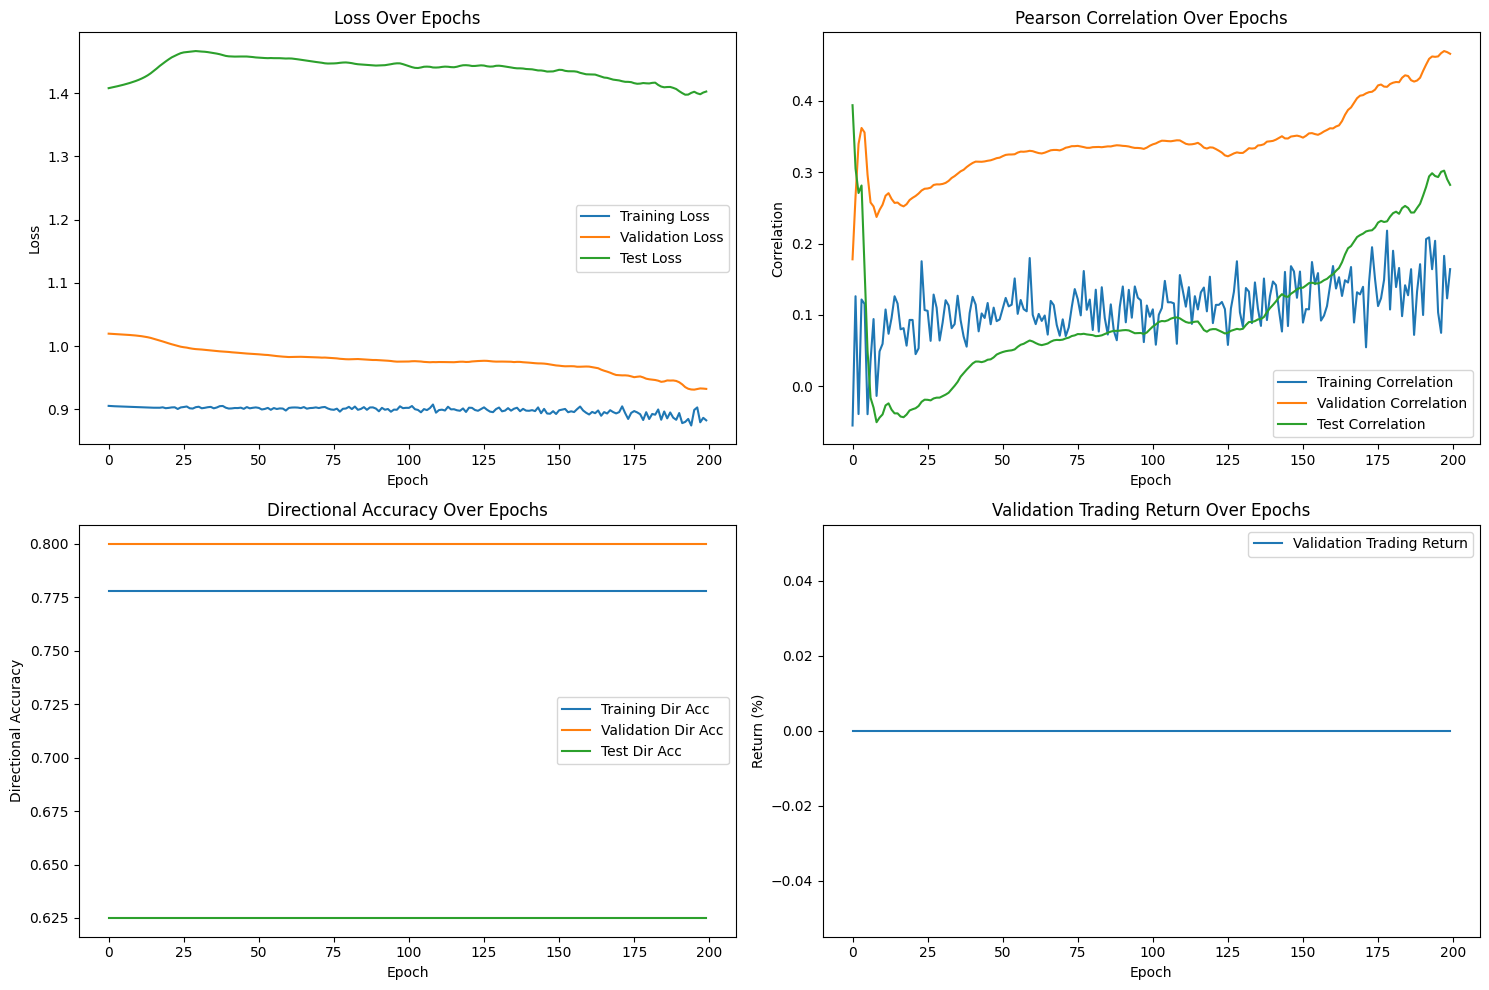

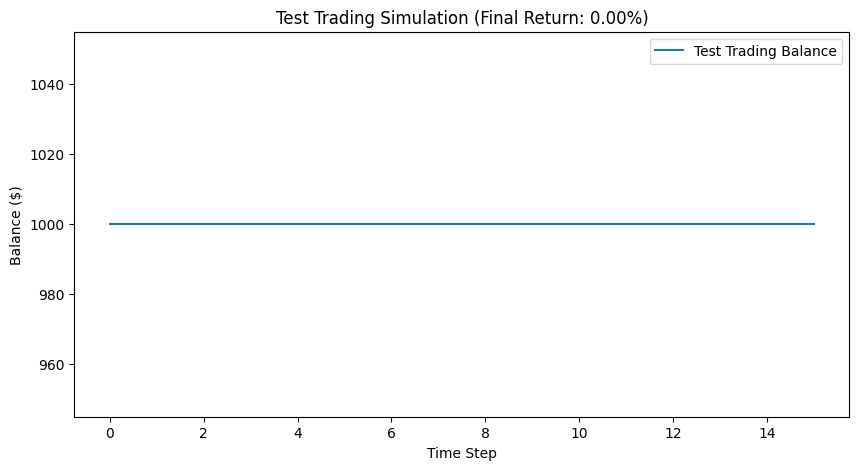

In [13]:

#_______________________________________________________________________________________________________________________________


# Load environment variables
load_dotenv()

# Reddit API setup
reddit = praw.Reddit(
    client_id=os.getenv("REDDIT_CLIENT_ID"),
    client_secret=os.getenv("REDDIT_CLIENT_SECRET"),
    user_agent="script:meme_coin_predictor:v1.0 (by u/Big_Seesaw_5202)"
)

# Configuration
MEME_COINS = [
    {
        "id": "official-trump",
        "reddit_query": "official trump OR trump coin OR $TRUMP OR meme coin"
    }
]
ANALYSIS_START_DATE = datetime(2025, 1, 17).date()
ANALYSIS_END_DATE = datetime(2025, 4, 29).date()
SUBREDDIT = "CryptoCurrency+WallStreetBets+Solana+CryptoMarkets+CryptoMoonShots"
MAX_POSTS = 5000
MAX_POSTS_PER_DAY = 50

# Global embedding cache
EMBEDDING_CACHE = {}
EMBEDDING_CACHE_FILE = "post_embeddings.pkl"

if os.path.exists(EMBEDDING_CACHE_FILE):
    try:
        with open(EMBEDDING_CACHE_FILE, 'rb') as f:
            EMBEDDING_CACHE.update(pickle.load(f))
        print(f"Loaded embedding cache with {len(EMBEDDING_CACHE)} entries")
    except Exception as e:
        print(f"Error loading embedding cache: {e}")

# Global normalization parameters
EMBEDDING_MEAN = None
EMBEDDING_STD = None

# Utility Functions
def remove_emojis(text: str) -> str:
    """Remove emojis from text."""
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

def anonymize_username(username: str) -> str:
    """Anonymize username using SHA256 hash."""
    return hashlib.sha256(username.encode()).hexdigest() if username else "anonymous"

def get_ollama_embedding(text, model='nomic-embed-text'):
    """Generate text embedding using Ollama's nomic-embed-text model."""
    text_hash = hashlib.sha256(text.encode()).hexdigest()
    if text_hash in EMBEDDING_CACHE:
        return EMBEDDING_CACHE[text_hash]
    try:
        response = ollama.embeddings(model=model, prompt=text)
        embedding = np.array(response['embedding'])
        EMBEDDING_CACHE[text_hash] = embedding
        return embedding
    except Exception as e:
        print(f"Error generating embedding for text: {e}")
        return np.zeros(768)  # Fallback to zero vector

def save_embedding_cache():
    """Save the embedding cache to disk."""
    try:
        with open(EMBEDDING_CACHE_FILE, 'wb') as f:
            pickle.dump(EMBEDDING_CACHE, f)
        print(f"Saved embedding cache with {len(EMBEDDING_CACHE)} entries")
    except Exception as e:
        print(f"Error saving embedding cache: {e}")

def get_llm_sentiment(post_text: str) -> int:
    """Predict sentiment score for a post using the BabyLlama neural network."""
    try:
        # Load the pre-trained BabyLlama model
        with open("BabyLlama.pkl", 'rb') as f:
            sentiment_model = pickle.load(f)  # Assumes Model.load is not needed if saved directly
        
        # Generate and normalize text embedding
        text_embedding = get_ollama_embedding(post_text)
        if EMBEDDING_MEAN is not None and EMBEDDING_STD is not None:
            text_embedding = (text_embedding - EMBEDDING_MEAN) / (EMBEDDING_STD + 1e-8)
        text_embedding = text_embedding.reshape(1, -1)  # Shape: (1, 768)
        
        # Predict sentiment score
        sentiment_score = sentiment_model.predict(text_embedding)[0, 0]
        sentiment_score = np.clip(float(sentiment_score), 1, 5)
        sentiment_score = int(round(sentiment_score))  # Convert to Python int
        
        print(f"Sentiment for '{post_text[:50]}...': {sentiment_score}")
        return sentiment_score
    except Exception as e:
        print(f"Sentiment prediction failed for '{post_text[:50]}...': {e}")
        with open("sentiment_errors.log", "a", encoding='utf-8') as f:
            f.write(f"Neural network failed for post '{post_text[:50]}...': {e}\n")
        return 3  # Neutral fallback

def process_post(post: dict, query: str) -> dict:
    """Process a single Reddit post with sentiment analysis."""
    # Skip processing if post has a valid sentiment score
    if "sentiment_score" in post and post["sentiment_score"] in range(1, 6):
        return post
    post["sentiment_score"] = get_llm_sentiment(post["text"])
    return post

def fetch_price_data(coin_id: str, start_date: datetime.date, end_date: datetime.date) -> dict:
    """Fetch historical price data from CoinGecko."""
    start_time = time.time()
    coingecko_api_key = os.getenv("COINGECKO_API_KEY")
    url = f"https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart/range"
    params = {
        'vs_currency': 'usd',
        'from': int(datetime.combine(start_date, datetime.min.time()).timestamp()),
        'to': int(datetime.combine(end_date, datetime.min.time()).timestamp())
    }
    headers = {'x-cg-demo-api-key': coingecko_api_key} if coingecko_api_key else {}
    
    try:
        response = requests.get(url, params=params, headers=headers, timeout=10)
        response.raise_for_status()
        data = response.json()
        prices = {datetime.fromtimestamp(price[0] / 1000).date(): price[1] for price in data['prices']}
        if end_date not in prices and prices:
            last_date = max(prices.keys())
            prices[end_date] = prices[last_date]
        print(f"Fetched {len(prices)} price points for {coin_id} from {min(prices.keys())} to {max(prices.keys())}")
        print(f"Price fetching took {time.time() - start_time:.2f} seconds")
        return prices
    except Exception as e:
        print(f"Error fetching price data for {coin_id}: {e}")
        with open("coingecko_errors.log", "a", encoding='utf-8') as f:
            f.write(f"Error for {coin_id} from {start_date} to {end_date}: {e}\n")
        return {}

def scrape_reddit_posts(query: str, start_date: datetime.date, end_date: datetime.date, max_posts: int, subreddit: str) -> list[dict]:
    """Scrape Reddit posts matching the query within the date range using search."""
    cache_file = "meme_coin_posts.json"
    print(f"Checking cache for posts for {query} from {start_date} to {end_date} in {subreddit}")
    
    if os.path.exists(cache_file):
        try:
            with open(cache_file, 'r', encoding='utf-8') as f:
                cached = json.load(f)
            if (cached.get('start_date') == start_date.strftime('%Y-%m-%d') and
                cached.get('end_date') == end_date.strftime('%Y-%m-%d') and
                cached.get('subreddit') == subreddit and
                all("sentiment_score" in post for post in cached.get('posts', []))):
                print(f"Loaded {len(cached['posts'])} cached posts from {cache_file}")
                return cached['posts']
        except Exception as e:
            print(f"Error loading cache: {e}")
            with open("cache_errors.log", "a", encoding='utf-8') as f:
                f.write(f"Error loading {cache_file}: {e}\n")
    
    print(f"No valid cache found, scraping posts with search")
    posts = []
    daily_posts_dict = defaultdict(list)
    
    try:
        start_time = time.time()
        submissions_processed = 0
        for submission in reddit.subreddit(subreddit).search(query, time_filter='year', limit=max_posts):
            time.sleep(0.05)
            submissions_processed += 1
            submission_date = datetime.fromtimestamp(submission.created_utc).date()
            print(f"Processing submission {submissions_processed} from {submission_date}")
            if submission_date < start_date or submission_date > end_date:
                print(f"Skipping: Outside date range {start_date} to {end_date}")
                continue
            title = remove_emojis(submission.title)
            selftext = remove_emojis(submission.selftext)
            text_lower = title.lower() + " " + selftext.lower()
            if any(term in text_lower for term in ['trump coin', 'official trump', '$trump', 'meme coin']):
                post_data = {
                    "text": title + " " + selftext,
                    "timestamp": datetime.fromtimestamp(submission.created_utc).strftime("%b %d, %Y %I:%M %p"),
                    "username": anonymize_username(submission.author.name if submission.author else None),
                    "upvotes": submission.score,
                    "num_comments": submission.num_comments,
                    "interactions": submission.score + submission.num_comments
                }
                daily_posts_dict[submission_date].append(post_data)
                print(f"Added post from {submission_date}: {post_data['text'][:50]}...")
            else:
                print(f"Skipping: No matching terms in '{text_lower[:50]}...'")
        
        for date, daily_posts in daily_posts_dict.items():
            daily_posts = sorted(daily_posts, key=lambda x: x["interactions"], reverse=True)[:max_posts_per_day]
            posts.extend(daily_posts)
            print(f"Collected {len(daily_posts)} posts for {date}")
        
        unique_posts = sorted(
            [dict(t) for t in {tuple(sorted(d.items())) for d in posts}],
            key=lambda x: x["interactions"],
            reverse=True
        )[:max_posts_per_day * ((end_date - start_date).days + 1)]
        
        # Process posts to add sentiment scores
        with ThreadPoolExecutor(max_workers=4) as executor:
            future_to_post = {executor.submit(process_post, post, query): post for post in unique_posts}
            processed_posts = []
            for future in as_completed(future_to_post):
                processed_post = future.result()
                processed_posts.append(processed_post)
                print(f"Processed post: {processed_post['text'][:50]}...")
        
        # Save to cache
        cache_data = {
            "start_date": start_date.strftime('%Y-%m-%d'),
            "end_date": end_date.strftime('%Y-%m-%d'),
            "subreddit": subreddit,
            "posts": processed_posts
        }
        with open(cache_file, 'w', encoding='utf-8') as f:
            json.dump(cache_data, f, ensure_ascii=False, indent=2)
        print(f"Saved {len(processed_posts)} posts to {cache_file}")
        print(f"Scraping took {time.time() - start_time:.2f} seconds")
        if not processed_posts:
            print("Warning: No posts collected. Check query, date range, or Reddit API access.")
        return processed_posts
    except Exception as e:
        print(f"Scraping failed: {e}")
        with open("reddit_errors.log", "a", encoding='utf-8') as f:
            f.write(f"Error for query '{query}' from {start_date} to {end_date}: {e}\n")
        return []

def collect_meme_coin_data(coins: list[dict], start_date: datetime.date, end_date: datetime.date) -> tuple:
    """Collect and preprocess data for all meme coins."""
    global EMBEDDING_MEAN, EMBEDDING_STD
    all_X, all_y = [], []
    for coin in coins:
        coin_id = coin["id"]
        reddit_query = coin["reddit_query"]
        print(f"Processing {coin_id}...")
        
        prices = fetch_price_data(coin_id, start_date, end_date)
        if not prices:
            print(f"No price data for {coin_id}, skipping")
            continue
        
        price_start_date = max(start_date, min(prices.keys()))
        price_end_date = min(end_date, max(prices.keys()))
        prices = {k: v for k, v in prices.items() if price_start_date <= k <= price_end_date}
        
        raw_posts = scrape_reddit_posts(reddit_query, start_date, end_date, MAX_POSTS, SUBREDDIT)
        if not raw_posts:
            print(f"No posts for {coin_id}, using fallback neutral sentiment")
            raw_posts = [
                {
                    "text": f"Discussion about {coin_id}",
                    "timestamp": (start_date + timedelta(days=i)).strftime("%b %d, %Y %I:%M %p"),
                    "username": "anonymous",
                    "upvotes": 1,
                    "num_comments": 0,
                    "interactions": 1,
                    "sentiment_score": np.random.choice([2, 3, 4])
                } for i in range((end_date - start_date).days + 1)
            ]
        
        # Compute normalization parameters for embeddings
        embeddings = [get_ollama_embedding(post["text"]) for post in raw_posts]
        embeddings = np.array([e for e in embeddings if np.any(e != 0)])  # Exclude zero vectors
        if len(embeddings) > 0:
            EMBEDDING_MEAN = np.mean(embeddings, axis=0)
            EMBEDDING_STD = np.std(embeddings, axis=0)
            print(f"Computed embedding normalization: mean={EMBEDDING_MEAN[:5]}, std={EMBEDDING_STD[:5]}")
        else:
            EMBEDDING_MEAN = np.zeros(768)
            EMBEDDING_STD = np.ones(768)
            print("No valid embeddings, using zero mean and unit std")
        
        # Save embedding cache
        save_embedding_cache()
        
        # Display sentiment scores for up to 5 randomly selected posts
        import random
        selected_posts = random.sample(raw_posts, min(5, len(raw_posts)))
        print(f"\nDisplaying sentiment scores for {len(selected_posts)} randomly selected posts:")
        for i, post in enumerate(selected_posts, 1):
            print(f"\nPost {i}: {post['text'][:50]}...")
            print(f"Sentiment Score: {post['sentiment_score']}")
        
        X, y = preprocess_data(raw_posts, prices, price_start_date, price_end_date, coin_id)
        if len(X) < 1:
            print(f"No data points for {coin_id}, skipping")
            continue
        
        all_X.append(X)
        all_y.append(y)
    
    if not all_X or not all_y:
        print("No valid data points collected, using fallback data")
        X = np.array([[3.0, 0.0, np.log1p(1), np.log1p(0)]] * 10)
        y = np.array([[0.0]] * 10)
        return X, y
    
    X = np.vstack(all_X)
    y = np.vstack(all_y)
    print(f"Collected {len(X)} total data points, X shape: {X.shape}, y shape: {y.shape}")
    return X, y

def preprocess_data(posts: list[dict], prices: dict, price_start_date: datetime.date, price_end_date: datetime.date, coin_id: str) -> tuple:
    """Preprocess posts and prices into neural network inputs."""
    start_time = time.time()
    daily_sentiment = {}
    daily_volume = {}
    daily_comments = {}
    daily_sentiment_var = {}
    
    print(f"Preprocessing {len(posts)} posts and {len(prices)} price points for {coin_id}")
    for post in posts:
        try:
            date = datetime.strptime(post["timestamp"], "%b %d, %Y %I:%M %p").date()
            if price_start_date <= date <= price_end_date:
                sentiment_score = post["sentiment_score"]
                upvotes = max(post.get("upvotes", 1), 1)
                num_comments = post.get("num_comments", 0)
                daily_sentiment.setdefault(date, []).append(sentiment_score)
                daily_volume[date] = daily_volume.get(date, 0) + upvotes
                daily_comments[date] = daily_comments.get(date, 0) + num_comments
                print(f"Post on {date}: Sentiment={sentiment_score}, Upvotes={upvotes}, Comments={num_comments}")
            else:
                print(f"Skipping post on {date}: Outside range {price_start_date} to {price_end_date}")
        except Exception as e:
            print(f"Error processing post: {e}")
            with open("preprocess_errors.log", "a", encoding='utf-8') as f:
                f.write(f"Error for {coin_id} on {post.get('timestamp', 'unknown')}: {e}\n")
    
    smoothed_sentiment = {}
    for date in sorted(daily_sentiment.keys()):
        window_dates = [date - timedelta(days=d) for d in range(-1, 2) if date - timedelta(days=d) in daily_sentiment]
        window_scores = [score for d in window_dates for score in daily_sentiment[d]]
        smoothed_sentiment[date] = np.mean(window_scores) if window_scores else daily_sentiment[date][0]
        daily_sentiment_var[date] = np.var(window_scores) if window_scores else 0.0
        print(f"Smoothed sentiment for, {date}: {smoothed_sentiment[date]:.2f}, Variance: {daily_sentiment_var[date]:.2f}")
    
    X, y = [], []
    current_date = price_start_date
    price_changes = []
    while current_date <= price_end_date:
        if current_date in prices:
            avg_sentiment = smoothed_sentiment.get(current_date, np.mean(list(smoothed_sentiment.values())) if smoothed_sentiment else 3.0)
            sentiment_var = daily_sentiment_var.get(current_date, 0.0)
            post_volume = np.log1p(daily_volume.get(current_date, 1))
            comment_volume = np.log1p(daily_comments.get(current_date, 0))
            prev_price = prices.get(current_date - timedelta(days=1), prices[current_date])
            price_change = (prices[current_date] - prev_price) / prev_price * 100
            window_changes = [price_changes[-i] for i in range(1, min(4, len(price_changes)+1)) if i <= len(price_changes)]
            smoothed_price_change = np.mean([price_change] + window_changes) if window_changes else price_change
            X.append([avg_sentiment, sentiment_var, post_volume, comment_volume])
            y.append([smoothed_price_change])
            price_changes.append(price_change)
            print(f"Data point for {current_date}: Sentiment={avg_sentiment:.2f}, Var={sentiment_var:.2f}, Volume={post_volume:.2f}, Comments={comment_volume:.2f}, Price Change={smoothed_price_change:.2f}%")
        else:
            print(f"Skipping {current_date}: No price data")
        current_date += timedelta(days=1)
    
    X = np.array(X)
    y = np.array(y)
    if len(X) < 10:
        print(f"Warning: Only {len(X)} data points collected. Consider broadening query or date range.")
    for i in range(X.shape[1]):
        if X[:, i].std() > 0:
            X[:, i] = (X[:, i] - X[:, i].mean()) / X[:, i].std()
    if len(price_changes) > 1 and y.std() > 0:
        y = (y - y.mean()) / y.std()
    
    print(f"Preprocessed {len(X)} data points for {coin_id}, X shape: {X.shape}, y shape: {y.shape}")
    print(f"Preprocessing took {time.time() - start_time:.2f} seconds")
    return X, y


In [ ]:

# Main Execution
if __name__ == "__main__":
    X, y = collect_meme_coin_data(MEME_COINS, ANALYSIS_START_DATE, ANALYSIS_END_DATE)
    if len(X) == 0:
        print("No data collected, using minimal dummy data for testing")
        X = np.array([[3.0, 0.0, np.log1p(1), np.log1p(0)]] * 10)
        y = np.array([[0.0]] * 10)

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    model = MrStonks()
    model.add(Layer_Dense(4, 128, weight_regularizer_l2=0.01))
    model.add(Activation_ReLU())
    model.add(Layer_Dropout(0.3))
    model.add(Layer_Dense(128, 64))
    model.add(Activation_ReLU())
    model.add(Layer_Dense(64, 32))
    model.add(Activation_ReLU())
    model.add(Layer_Dense(32, 1))
    model.add(Activation_Linear())
    model.set(
        loss=Loss_MeanSquaredError(),
        optimizer=Optimizer_Adam(learning_rate=0.001, decay=1e-4),
        accuracy=Accuracy_Regression()
    )
    model.finalize()

    model.train(X_train, y_train, X_val, y_val, X_test, y_test, epochs=200, batch_size=16, print_every=10, patience=50)

In [11]:
# Cell: Compare BabyLlama and New LLM Sentiment Scores
import numpy as np
import pandas as pd
import os
import json
import pickle
import praw
import hashlib
import re
from datetime import datetime
from dotenv import load_dotenv
import ollama
from pydantic import BaseModel, Field

# Load environment variables
load_dotenv()

# Reddit API setup
reddit = praw.Reddit(
    client_id=os.getenv("REDDIT_CLIENT_ID"),
    client_secret=os.getenv("REDDIT_CLIENT_SECRET"),
    user_agent="script:meme_coin_predictor:v1.0 (by u/Big_Seesaw_5202)"
)

# Configuration
QUERY = "official trump OR trump coin OR $TRUMP OR meme coin OR TRUMP token OR Trump meme"
SUBREDDIT = "CryptoCurrency+WallStreetBets+Solana+CryptoMarkets+CryptoMoonShots+SatoshiStreetBets+altcoin"
START_DATE = datetime(2024, 12, 1).date()  # Extended to get more posts
END_DATE = datetime(2025, 4, 29).date()
MAX_POSTS = 10
CACHE_FILE = "meme_coin_posts.json"
EMBEDDING_CACHE_FILE = "post_embeddings.pkl"

# Embedding cache
EMBEDDING_CACHE = {}
if os.path.exists(EMBEDDING_CACHE_FILE):
    try:
        with open(EMBEDDING_CACHE_FILE, 'rb') as f:
            EMBEDDING_CACHE.update(pickle.load(f))
        print(f"Loaded embedding cache with {len(EMBEDDING_CACHE)} entries")
    except Exception as e:
        print(f"Error loading embedding cache: {e}")

# Pydantic model for new LLM sentiment score
class SentimentScore(BaseModel):
    score: int = Field(ge=1, le=5, description="Sentiment score from 1 (very negative) to 5 (very positive)")



# ------------------------- Neural Network Components -------------------------
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons, weight_regularizer_l1=0, weight_regularizer_l2=0, bias_regularizer_l1=0, bias_regularizer_l2=0):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
        return self.output

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        if self.weight_regularizer_l1 > 0:
            dl1 = np.ones_like(self.weights)
            dl1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dl1
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights
        if self.bias_regularizer_l1 > 0:
            dl1 = np.ones_like(self.biases)
            dl1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dl1
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases
        self.dinputs = np.dot(dvalues, self.weights.T)
        return self.dinputs

    def get_parameters(self):
        return self.weights, self.biases

    def set_parameters(self, weights, biases):
        self.weights = weights
        self.biases = biases

class Layer_Dropout:
    def __init__(self, rate):
        self.rate = 1 - rate

    def forward(self, inputs, training):
        self.inputs = inputs
        if not training:
            self.output = inputs.copy()
        else:
            self.binary_mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate
            self.output = inputs * self.binary_mask
        return self.output

    def backward(self, dvalues):
        self.dinputs = dvalues * self.binary_mask
        return self.dinputs

class Layer_Input:
    def forward(self, inputs, training):
        self.output = inputs
        return self.output

class Activation_ReLU:
    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
        return self.output

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0
        return self.dinputs

    def predictions(self, outputs):
        return outputs

class Activation_Linear:
    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = inputs
        return self.output

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        return self.dinputs

    def predictions(self, outputs):
        return outputs


class Optimizer_SGD:
    def __init__(self, learning_rate=1., decay=0., momentum=0., clipnorm=1.0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
        self.clipnorm = clipnorm

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_cache = self.momentum * layer.weight_cache - self.current_learning_rate * layer.dweights
        layer.bias_cache = self.momentum * layer.bias_cache - self.current_learning_rate * layer.dbiases

        norm = np.sqrt(np.sum(layer.dweights**2) + np.sum(layer.dbiases**2))
        if norm > self.clipnorm:
            scale = self.clipnorm / (norm + 1e-8)
            layer.dweights *= scale
            layer.dbiases *= scale

        layer.weights += layer.weight_cache
        layer.biases += layer.bias_cache

    def post_update_params(self):
        self.iterations += 1



class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights ** 2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases ** 2

        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

    def post_update_params(self):
        self.iterations += 1

class Loss:
    def regularization_loss(self):
        regularization_loss = 0
        for layer in self.trainable_layers:
            if layer.weight_regularizer_l1 > 0:
                regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
            if layer.weight_regularizer_l2 > 0:
                regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)
            if layer.bias_regularizer_l1 > 0:
                regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))
            if layer.bias_regularizer_l2 > 0:
                regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)
        return regularization_loss

    def remember_trainable_layers(self, trainable_layers):
        self.trainable_layers = trainable_layers

    def calculate(self, output, y, *, include_regularization=False):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        self.accumulated_sum += np.sum(sample_losses)
        self.accumulated_count += len(sample_losses)
        if not include_regularization:
            return data_loss
        return data_loss, self.regularization_loss()

    def calculate_accumulated(self, *, include_regularization=False):
        data_loss = self.accumulated_sum / self.accumulated_count
        if not include_regularization:
            return data_loss
        return data_loss, self.regularization_loss()

    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0

class Loss_MeanSquaredError(Loss):
    def forward(self, y_pred, y_true):
        return np.mean((y_true - y_pred) ** 2, axis=-1)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        self.dinputs = -2 * (y_true - dvalues) / outputs
        self.dinputs = self.dinputs / samples

class Accuracy_Regression:
    def __init__(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0
        self.directional_sum = 0
        self.directional_count = 0
        self.mae_sum = 0
        self.y_min = None
        self.y_max = None

    def init(self, y):
        self.y_min = np.min(y)
        self.y_max = np.max(y)

    def denormalize(self, y):
        return y * (self.y_max - self.y_min) + self.y_min

    def calculate(self, predictions, y):
        predictions_denorm = self.denormalize(predictions)
        y_denorm = self.denormalize(y)
        correlation = pearson_correlation(y_denorm, predictions_denorm)
        self.accumulated_sum += correlation * len(y)
        self.accumulated_count += len(y)
        dir_acc = directional_accuracy(y_denorm, predictions_denorm)
        self.directional_sum += dir_acc * len(y)
        self.directional_count += len(y)
        mae = mean_absolute_error(y_denorm, predictions_denorm)
        self.mae_sum += mae * len(y)
        return correlation, dir_acc, mae

    def calculate_accumulated(self):
        if self.accumulated_count == 0:
            return 0, 0, 0
        return (
            self.accumulated_sum / self.accumulated_count,
            self.directional_sum / self.directional_count,
            self.mae_sum / self.accumulated_count
        )

    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0
        self.directional_sum = 0
        self.directional_count = 0
        self.mae_sum = 0

def pearson_correlation(y_true, y_pred):
    y_true_mean = np.mean(y_true)
    y_pred_mean = np.mean(y_pred)
    num = np.sum((y_true - y_true_mean) * (y_pred - y_pred_mean))
    denom = np.sqrt(np.sum((y_true - y_true_mean) ** 2) * np.sum((y_pred - y_pred_mean) ** 2))
    return num / denom if denom != 0 else 0

def directional_accuracy(y_true, y_pred):
    direction_correct = np.sign(y_true) == np.sign(y_pred)
    return np.mean(direction_correct)

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def simulate_trading(y_true, y_pred, initial_balance=1000, fee=0.001, threshold=0.5):
    balance = initial_balance
    position = 0  # 0: no position, 1: long
    returns = []
    for true_change, pred_change in zip(y_true.flatten(), y_pred.flatten()):
        if pred_change > threshold and position == 0:  # Buy
            position = 1
            balance *= (1 - fee)
        elif pred_change < -threshold and position == 1:  # Sell
            position = 0
            balance *= (1 - fee) * (1 + true_change / 100)
        returns.append(balance)
    final_return = (balance - initial_balance) / initial_balance * 100
    return final_return, returns



# BabyLlama Model class (as provided)
class Model:
    def __init__(self):
        self.layers = []
    def add(self, layer):
        self.layers.append(layer)
    def set(self, *, loss, optimizer, accuracy):
        if loss is not None:
            self.loss = loss
        if optimizer is not None:
            self.optimizer = optimizer
        if accuracy is not None:
            self.accuracy = accuracy
    def finalize(self):
        self.input_layer = Layer_Input()
        layer_count = len(self.layers)
        self.trainable_layers = []
        for i in range(layer_count):
            if i == 0:
                self.layers[i].prev = self.input_layer
                self.layers[i].next = self.layers[i + 1]
            elif i < layer_count - 1:
                self.layers[i].prev = self.layers[i - 1]
                self.layers[i].next = self.layers[i + 1]
            else:
                self.layers[i].prev = self.layers[i - 1]
                self.layers[i].next = self.loss
                self.output_layer_activation = self.layers[i]
            if hasattr(self.layers[i], 'weights'):
                self.trainable_layers.append(self.layers[i])
        if self.loss is not None:
            self.loss.remember_trainable_layers(self.trainable_layers)
    def forward(self, X, training):
        self.input_layer.forward(X, training)
        output = self.input_layer.output
        for layer in self.layers:
            output = layer.forward(output, training)
        return output
    def backward(self, output, y):
        dvalues = self.loss.backward(output, y)
        for layer in reversed(self.layers):
            dvalues = layer.backward(dvalues)
        return dvalues
    def train(self, X, y, *, epochs=1, batch_size=None, print_every=1, validation_data=None):
        self.history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
        train_steps = 1
        if batch_size is not None:
            train_steps = len(X) // batch_size
            if train_steps * batch_size < len(X):
                train_steps += 1
        for epoch in range(1, epochs + 1):
            print(f'epoch: {epoch}')
            self.loss.new_pass()
            self.accuracy.new_pass()
            for step in range(train_steps):
                batch_X = X if batch_size is None else X[step * batch_size:(step + 1) * batch_size]
                batch_y = y if batch_size is None else y[step * batch_size:(step + 1) * batch_size]
                output = self.forward(batch_X, training=True)
                data_loss, regularization_loss = self.loss.calculate(output, batch_y, include_regularization=True)
                loss = data_loss + regularization_loss
                accuracy = self.accuracy.calculate(output, batch_y)
                self.backward(output, batch_y)
                self.optimizer.pre_update_params()
                for layer in self.trainable_layers:
                    self.optimizer.update_params(layer)
                self.optimizer.post_update_params()
                if not step % print_every or step == train_steps - 1:
                    print(f'step: {step}, acc: {accuracy:.3f}, loss: {loss:.3f}, '
                          f'(data_loss: {data_loss:.3f}, reg_loss: {regularization_loss:.3f}), '
                          f'lr: {self.optimizer.current_learning_rate}')
            epoch_data_loss, epoch_regularization_loss = self.loss.calculate_accumulated(include_regularization=True)
            epoch_loss = epoch_data_loss + epoch_regularization_loss
            epoch_accuracy = self.accuracy.calculate_accumulated()
            self.history['train_loss'].append(epoch_loss)
            self.history['train_acc'].append(epoch_accuracy)
            print(f'training, acc: {epoch_accuracy:.3f}, loss: {epoch_loss:.3f}, '
                  f'(data_loss: {epoch_data_loss:.3f}, reg_loss: {epoch_regularization_loss:.3f}), '
                  f'lr: {self.optimizer.current_learning_rate}')
            if validation_data is not None:
                X_val, y_val = validation_data
                val_loss, val_acc = self.evaluate(X_val, y_val, batch_size=batch_size)
                self.history['val_loss'].append(val_loss)
                self.history['val_acc'].append(val_acc)
            else:
                self.history['val_loss'].append(None)
                self.history['val_acc'].append(None)
        return self.history
    def evaluate(self, X_val, y_val, *, batch_size=None):
        validation_steps = 1
        if batch_size is not None:
            validation_steps = len(X_val) // batch_size
            if validation_steps * batch_size < len(X_val):
                validation_steps += 1
        self.loss.new_pass()
        self.accuracy.new_pass()
        for step in range(validation_steps):
            batch_X = X_val if batch_size is None else X_val[step * batch_size:(step + 1) * batch_size]
            batch_y = y_val if batch_size is None else y_val[step * batch_size:(step + 1) * batch_size]
            output = self.forward(batch_X, training=False)
            self.loss.calculate(output, batch_y)
            self.accuracy.calculate(output, batch_y)
        validation_loss = self.loss.calculate_accumulated()
        validation_accuracy = self.accuracy.calculate_accumulated()
        print(f'validation, acc: {validation_accuracy:.3f}, loss: {validation_loss:.3f}')
        return validation_loss, validation_accuracy
    def predict(self, X, *, batch_size=None):
        prediction_steps = 1
        if batch_size is not None:
            prediction_steps = len(X) // batch_size
            if prediction_steps * batch_size < len(X):
                prediction_steps += 1
        output = []
        for step in range(prediction_steps):
            batch_X = X if batch_size is None else X[step * batch_size:(step + 1) * batch_size]
            batch_output = self.forward(batch_X, training=False)
            output.append(batch_output)
        return np.vstack(output)
    def save(self, filename):
        model_data = {
            'layers': [],
            'loss': self.loss,
            'optimizer': self.optimizer,
            'accuracy': self.accuracy,
            'trainable_layers': []
        }
        for layer in self.layers:
            layer_data = {
                'class_name': layer.__class__.__name__,
                'attributes': {}
            }
            if isinstance(layer, Layer_Dense):
                layer_data['attributes'] = {
                    'weights': layer.weights,
                    'biases': layer.biases,
                    'weight_regularizer_l1': layer.weight_regularizer_l1,
                    'weight_regularizer_l2': layer.weight_regularizer_l2,
                    'bias_regularizer_l1': layer.bias_regularizer_l1,
                    'bias_regularizer_l2': layer.bias_regularizer_l2
                }
            elif isinstance(layer, Layer_Dropout):
                layer_data['attributes'] = {
                    'rate': layer.rate
                }
            elif isinstance(layer, (Activation_ReLU, Activation_Linear)):
                layer_data['attributes'] = {}
            model_data['layers'].append(layer_data)
        for layer in self.trainable_layers:
            layer_idx = next(i for i, l in enumerate(self.layers) if l is layer)
            model_data['trainable_layers'].append(layer_idx)
        with open(filename, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"Model saved to {filename}")
    @staticmethod
    def load(filename):
        with open(filename, 'rb') as f:
            model_data = pickle.load(f)
        model = Model()
        model.layers = []
        layer_map = {
            'Layer_Dense': Layer_Dense,
            'Layer_Dropout': Layer_Dropout,
            'Activation_ReLU': Activation_ReLU,
            'Activation_Linear': Activation_Linear
        }
        for layer_data in model_data['layers']:
            class_name = layer_data['class_name']
            attrs = layer_data['attributes']
            if class_name == 'Layer_Dense':
                temp_layer = Layer_Dense(1, 1)
                layer = Layer_Dense(
                    n_inputs=attrs['weights'].shape[0],
                    n_neurons=attrs['weights'].shape[1],
                    weight_regularizer_l1=attrs['weight_regularizer_l1'],
                    weight_regularizer_l2=attrs['weight_regularizer_l2'],
                    bias_regularizer_l1=attrs['bias_regularizer_l1'],
                    bias_regularizer_l2=attrs['bias_regularizer_l2']
                )
                layer.weights = attrs['weights']
                layer.biases = attrs['biases']
            elif class_name == 'Layer_Dropout':
                layer = Layer_Dropout(rate=attrs['rate'])
            elif class_name in ['Activation_ReLU', 'Activation_Linear']:
                layer = layer_map[class_name]()
            else:
                raise ValueError(f"Unsupported layer type: {class_name}")
            model.add(layer)
        model.set(
            loss=model_data['loss'],
            optimizer=model_data['optimizer'],
            accuracy=model_data['accuracy']
        )
        model.trainable_layers = [model.layers[idx] for idx in model_data['trainable_layers']]
        model.finalize()
        print(f"Model loaded from {filename}")
        return model

# Normalization parameters
EMBEDDING_MEAN = None
EMBEDDING_STD = None
# Uncomment to load saved parameters
# with open("embedding_stats.pkl", 'rb') as f:
#     stats = pickle.load(f)
#     EMBEDDING_MEAN = stats["mean"]
#     EMBEDDING_STD = stats["std"]

# Utility functions
def remove_emojis(text: str) -> str:
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

def anonymize_username(username: str) -> str:
    return hashlib.sha256(username.encode()).hexdigest() if username else "anonymous"

def get_ollama_embedding(text, model='nomic-embed-text'):
    text_hash = hashlib.sha256(text.encode()).hexdigest()
    if text_hash in EMBEDDING_CACHE:
        return EMBEDDING_CACHE[text_hash]
    try:
        response = ollama.embeddings(model=model, prompt=text)
        embedding = np.array(response['embedding'])
        EMBEDDING_CACHE[text_hash] = embedding
        return embedding
    except Exception as e:
        print(f"Error generating embedding for text: {e}")
        return np.zeros(768)

def save_embedding_cache():
    try:
        with open(EMBEDDING_CACHE_FILE, 'wb') as f:
            pickle.dump(EMBEDDING_CACHE, f)
        print(f"Saved embedding cache with {len(EMBEDDING_CACHE)} entries")
    except Exception as e:
        print(f"Error saving embedding cache: {e}")

# New LLM sentiment function with Pydantic
def get_new_llm_sentiment(post_text: str, model='llama3') -> int:
    try:
        prompt = (
            "Analyze the sentiment of the following Reddit post about the 'official trump' meme coin. "
            "Return a sentiment score from 1 (very negative) to 5 (very positive) based on the post's tone "
            "and content regarding the coin. Focus only on the sentiment toward the coin, ignoring unrelated topics. "
            "Provide the score as a single integer.\n\n"
            f"Post: {post_text[:1000]}..."  # Truncate for LLM
        )
        response = ollama.generate(
            model=model,
            prompt=prompt,
            format="json",
            options={"temperature": 0.0}
        )
        parsed_response = SentimentScore.parse_raw(response['response'])
        print(f"New LLM sentiment for '{post_text[:50]}...': {parsed_response.score}")
        return parsed_response.score
    except Exception as e:
        print(f"New LLM sentiment failed for '{post_text[:50]}...': {e}")
        return 3  # Neutral fallback

# BabyLlama sentiment function
def get_babyllama_sentiment(post_text: str) -> int:
    try:
        with open("BabyLlama.pkl", 'rb') as f:
            sentiment_model = Model.load("BabyLlama.pkl")
        text_embedding = get_ollama_embedding(post_text)
        if EMBEDDING_MEAN is not None and EMBEDDING_STD is not None:
            text_embedding = (text_embedding - EMBEDDING_MEAN) / (EMBEDDING_STD + 1e-8)
        text_embedding = text_embedding.reshape(1, -1)
        sentiment_score = sentiment_model.predict(text_embedding)[0, 0]
        sentiment_score = np.clip(float(sentiment_score), 1, 5)
        sentiment_score = int(round(sentiment_score))
        print(f"BabyLlama sentiment for '{post_text[:50]}...': {sentiment_score}")
        return sentiment_score
    except Exception as e:
        print(f"BabyLlama sentiment failed for '{post_text[:50]}...': {e}")
        return 3

# Get posts
posts = []
if os.path.exists(CACHE_FILE):
    try:
        with open(CACHE_FILE, 'r', encoding='utf-8') as f:
            cached = json.load(f)
        posts = cached.get('posts', [])[:MAX_POSTS]
        print(f"Loaded {len(posts)} posts from cache")
    except Exception as e:
        print(f"Error loading cache: {e}")

if not posts:
    print("No cached posts, scraping new ones")
    try:
        for submission in reddit.subreddit(SUBREDDIT).search(QUERY, time_filter='year', limit=MAX_POSTS):
            submission_date = datetime.fromtimestamp(submission.created_utc).date()
            if submission_date < START_DATE or submission_date > END_DATE:
                continue
            title = remove_emojis(submission.title)
            selftext = remove_emojis(submission.selftext)
            text_lower = title.lower() + " " + selftext.lower()
            if any(term in text_lower for term in ['trump coin', 'official trump', '$trump', 'meme coin', 'trump token', 'trump meme']):
                posts.append({
                    "text": title + " " + selftext,
                    "timestamp": datetime.fromtimestamp(submission.created_utc).strftime("%b %d, %Y %I:%M %p")
                })
        print(f"Scraped {len(posts)} posts")
    except Exception as e:
        print(f"Scraping failed: {e}")
        posts = [{"text": "Sample post about official trump coin", "timestamp": "Jan 17, 2025 12:00 PM"}]

# Compute normalization parameters if not set
if EMBEDDING_MEAN is None or EMBEDDING_STD is None:
    embeddings = [get_ollama_embedding(post["text"]) for post in posts]
    embeddings = np.array([e for e in embeddings if np.any(e != 0)])
    if len(embeddings) > 0:
        EMBEDDING_MEAN = np.mean(embeddings, axis=0)
        EMBEDDING_STD = np.std(embeddings, axis=0)
        print(f"Computed normalization: mean={EMBEDDING_MEAN[:5]}, std={EMBEDDING_STD[:5]}")
    else:
        EMBEDDING_MEAN = np.zeros(768)
        EMBEDDING_STD = np.ones(768)
        print("No valid embeddings, using zero mean and unit std")

# Generate table
results = []
for post in posts[:MAX_POSTS]:
    new_score = get_new_llm_sentiment(post["text"])
    babyllama_score = get_babyllama_sentiment(post["text"])
    results.append({
        "Post Text": post["text"][:100] + "..." if len(post["text"]) > 100 else post["text"],
        "New LLM Score": new_score,
        "BabyLlama Score": babyllama_score
    })

df = pd.DataFrame(results)
pd.set_option('display.max_colwidth', 100)
display(df)
print("\nNew LLM Score Distribution:")
print(df["New LLM Score"].value_counts().sort_index())
print("\nBabyLlama Score Distribution:")
print(df["BabyLlama Score"].value_counts().sort_index())

# Save embedding cache
save_embedding_cache()

Loaded embedding cache with 7 entries
No cached posts, scraping new ones
Scraped 5 posts
Computed normalization: mean=[ 0.26150737  1.74576774 -3.14139848 -0.3959875   1.29648929], std=[0.67411347 0.3457263  0.3737727  0.33015122 0.52490463]


C:\Users\cha\AppData\Local\Temp\ipykernel_10144\3752685185.py:596: PydanticDeprecatedSince20: The `parse_raw` method is deprecated; if your data is JSON use `model_validate_json`, otherwise load the data then use `model_validate` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  parsed_response = SentimentScore.parse_raw(response['response'])


New LLM sentiment for 'Official Trump Coin Price Falls 90% As $340M Token...': 1
Model loaded from BabyLlama.pkl
BabyLlama sentiment for 'Official Trump Coin Price Falls 90% As $340M Token...': 3
New LLM sentiment for 'Mark Cuban Rants on Meme Coins, Proposes Using The...': 2
Model loaded from BabyLlama.pkl
BabyLlama sentiment for 'Mark Cuban Rants on Meme Coins, Proposes Using The...': 3
New LLM sentiment for 'Trump (TRUMP) Meme Coin Surges to $19 as Market Sp...': 4
Model loaded from BabyLlama.pkl
BabyLlama sentiment for 'Trump (TRUMP) Meme Coin Surges to $19 as Market Sp...': 3
New LLM sentiment failed for 'Join the $CXPT Whitelist and Be Part of a Fun, Aut...': 1 validation error for SentimentScore
score
  Field required [type=missing, input_value={}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/missing
Model loaded from BabyLlama.pkl
BabyLlama sentiment for 'Join the $CXPT Whitelist and Be Part of a Fun, Aut...': 4
New LLM sentiment failed 

,Post Text,New LLM Score,BabyLlama Score
0,Official Trump Coin Price Falls 90% As $340M Token Unlock Looms,1,3
1,"Mark Cuban Rants on Meme Coins, Proposes Using Them to 'Dent' U.S. Debt",2,3
2,Trump (TRUMP) Meme Coin Surges to $19 as Market Speculates on Trump’s Long-Term Hold. $100+ inco...,4,3
3,"Join the $CXPT Whitelist and Be Part of a Fun, Authentic Community NiHao, comrades of Reddit! It...",3,4
4,List of impeachable offenses Donald Trump has committed by launching meme coins 1. Securities...,3,3



New LLM Score Distribution:
New LLM Score
1    1
2    1
3    2
4    1
Name: count, dtype: int64

BabyLlama Score Distribution:
BabyLlama Score
3    4
4    1
Name: count, dtype: int64
Saved embedding cache with 7 entries
